<a href="https://colab.research.google.com/github/kshitiz510/UCS-654/blob/main/Assignmnet-6-Data-Generation-using-Simulation/sumo_simulation_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!apt-get update -qq
!apt-get install -y sumo sumo-tools
!pip install traci numpy pandas scikit-learn matplotlib

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
sumo is already the newest version (1.12.0+dfsg1-1).
sumo-tools is already the newest version (1.12.0+dfsg1-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [4]:
import os
import subprocess
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [20]:
nodes_xml = """<nodes>
    <node id="n1" x="0" y="0"/>
    <node id="n2" x="1000" y="0"/>
</nodes>"""

with open("nodes.nod.xml", "w") as f:
    f.write(nodes_xml)

In [21]:
edges_xml = """<edges>
    <edge id="e1" from="n1" to="n2" numLanes="1" speed="13.9"/>
</edges>"""

with open("edges.edg.xml", "w") as f:
    f.write(edges_xml)


In [22]:
!netconvert -n nodes.nod.xml -e edges.edg.xml -o network.net.xml

Success.


In [24]:
def generate_routes(flow_veh_per_hour, sim_duration=3600):
    arrival_rate = flow_veh_per_hour / 3600

    root = ET.Element("routes")

    ET.SubElement(
        root, "vType",
        id="passenger",
        vClass="passenger"
    )

    ET.SubElement(
        root, "route",
        id="r1",
        edges="e1"
    )

    time = 0.0
    veh_id = 0

    max_depart_time = sim_duration - 150

    while time < max_depart_time:
        inter_arrival = np.random.exponential(1 / arrival_rate)
        time += inter_arrival

        ET.SubElement(
            root, "vehicle",
            id=f"veh{veh_id}",
            type="passenger",
            route="r1",
            depart=f"{time:.2f}"
        )

        veh_id += 1

    ET.ElementTree(root).write("routes.rou.xml")
    return veh_id


In [25]:
def run_sumo_simulation():
    if os.path.exists("tripinfo.xml"):
        os.remove("tripinfo.xml")

    cmd = [
        "sumo",
        "-n", "network.net.xml",
        "-r", "routes.rou.xml",
        "--tripinfo-output", "tripinfo.xml",
        "--end", "4000",
        "--no-step-log", "true",
        "--duration-log.disable", "true"
    ]

    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    if not os.path.exists("tripinfo.xml"):
        return None

    tree = ET.parse("tripinfo.xml")
    root = tree.getroot()

    durations = [
        float(trip.attrib["duration"])
        for trip in root
        if "duration" in trip.attrib
    ]

    if len(durations) == 0:
        return None

    return np.mean(durations)


In [26]:
flow_test = 1200
vehicles = generate_routes(flow_test)
avg_time = run_sumo_simulation()

print("Vehicles generated:", vehicles)
print("Average travel time:", avg_time)


Vehicles generated: 1197
Average travel time: 88.41771094402674


In [27]:
data = []

while len(data) < 1000:
    flow = np.random.uniform(600, 1800)

    vehicle_count = generate_routes(flow)
    avg_time = run_sumo_simulation()

    if avg_time is None:
        continue

    data.append([
        flow,
        vehicle_count,
        avg_time
    ])

print("Valid simulations:", len(data))


Valid simulations: 1000


In [31]:
df = pd.DataFrame(
    data,
    columns=[
        "traffic_flow_veh_per_hour",
        "vehicle_count",
        "avg_travel_time"
    ]
)

df.head()


,traffic_flow_veh_per_hour,vehicle_count,avg_travel_time
0,631.015359,590,83.571186
1,1368.158289,1351,88.441538
2,838.738127,788,85.120558
3,1103.467889,1029,87.366375
4,1642.516199,1587,88.458462


In [32]:
X = df[["traffic_flow_veh_per_hour", "vehicle_count"]]
y = df["avg_travel_time"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "SVR": SVR()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    results.append([
        name,
        r2_score(y_test, preds),
        mean_squared_error(y_test, preds)
    ])

results_df = pd.DataFrame(
    results,
    columns=["Model", "R2 Score", "MSE"]
).sort_values("R2 Score", ascending=False)

results_df


,Model,R2 Score,MSE
5,Gradient Boosting,0.994302,0.015284
4,Random Forest,0.993388,0.017737
6,SVR,0.991501,0.022798
3,Decision Tree,0.987888,0.032489
0,Linear,0.765931,0.627870
1,Ridge,0.765931,0.627870
2,Lasso,0.765815,0.628183


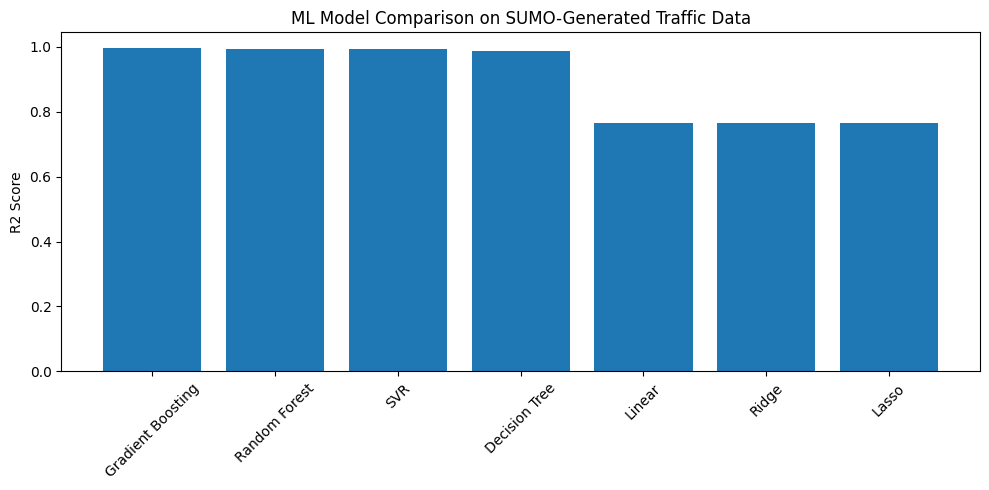

In [33]:
plt.figure(figsize=(10, 5))
plt.bar(results_df["Model"], results_df["R2 Score"])
plt.xticks(rotation=45)
plt.ylabel("R2 Score")
plt.title("ML Model Comparison on SUMO-Generated Traffic Data")
plt.tight_layout()
plt.show()


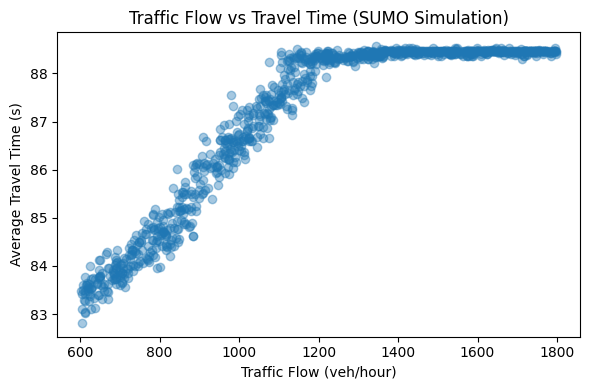

In [35]:
plt.figure(figsize=(6,4))
plt.scatter(
    df["traffic_flow_veh_per_hour"],
    df["avg_travel_time"],
    alpha=0.4
)
plt.xlabel("Traffic Flow (veh/hour)")
plt.ylabel("Average Travel Time (s)")
plt.title("Traffic Flow vs Travel Time (SUMO Simulation)")
plt.tight_layout()
plt.show()
